## IBM Machine Learning Course Lab 4 - Non-Linear Regression

This is my own attempt at Lab 4 of 'Machine Learning with Python' by IBM on Coursera. It includes my own insight when solving problems. The method of analysis presented here is far more rigorous than that required by the course.

In [202]:
""" importing necessary packages """
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [8]:
""" Importing the data set """

!wget -nv -O china_gdp.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/china_gdp.csv
    
df = pd.read_csv("china_gdp.csv")
df.head(10)

2020-07-24 16:17:45 URL:https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/china_gdp.csv [1218/1218] -> "china_gdp.csv" [1]


,Year,Value
0,1960,5.918412e+10
1,1961,4.955705e+10
2,1962,4.668518e+10
3,1963,5.009730e+10
4,1964,5.906225e+10
5,1965,6.970915e+10
6,1966,7.587943e+10
7,1967,7.205703e+10
8,1968,6.999350e+10
9,1969,7.871882e+10


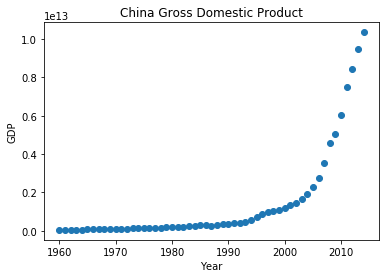

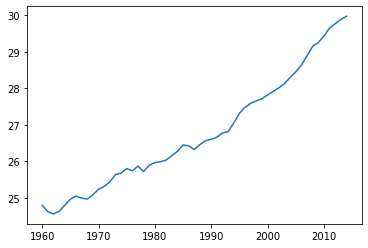

In [15]:
plt.plot(df.Year, df.Value,'o')
plt.title('China Gross Domestic Product')
plt.xlabel('Year')
plt.ylabel('GDP')
plt.show()
#what type of model can we use to model this? It looks exponential, what happens if we plot GDP vs. exp X?

plt.plot(df.Year,np.log(df.Value))

#as we can see, though the log transfom linearises the curve even more, it appears that it does not do a great
#job. It may be possible to now do a polynomial fit on this data, but that way we complicate 
# the process, What other functions could we try?

## Other functions

The IBM course chooses to model this curve using a sigmoid function, however, seeing as the graph only slightly shows this trend, I find it to be slightly unconvincing, so I will try a number of different functions.

In [161]:

def sigmoid(x, Beta_1, Beta_2):
     y = 1 / (1 + np.exp(-Beta_1*(x-Beta_2)))
     return y
#note, the exponential has been taken down below
#note, the exponental has been removed as it does not fit the model well. 

## Optimizing

In [162]:
from scipy.optimize import curve_fit

x_data, y_data = (df["Year"].values, df["Value"].values)

xdata = x_data/max(x_data)
ydata = y_data/max(y_data)


popt2,pcov2 = curve_fit(sigmoid, xdata,ydata)
#popt, pcov = curve_fit(exponent, x_exp,y_exp)
print(popt)


[-0.52035337  0.38075202  1.        ]


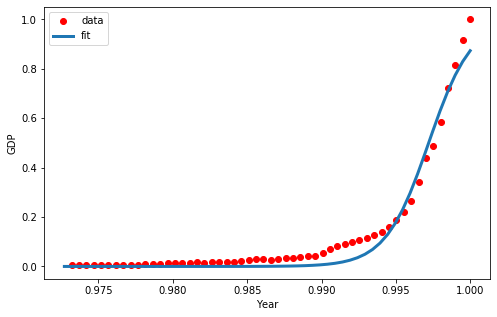

In [164]:
x = np.linspace(1960, 2015, 55)


x = x/max(x)
plt.figure(figsize=(8,5))
y = sigmoid(x, *popt2)
plt.plot(xdata, ydata, 'ro', label='data')
plt.plot(x,y, linewidth=3.0, label='fit')







plt.legend(loc='best')
plt.ylabel('GDP')
plt.xlabel('Year')
plt.show()


#not sure why the exponential optimization is not working. Need to figure this out. 

[0.0117815  1.03776383 7.98248827]


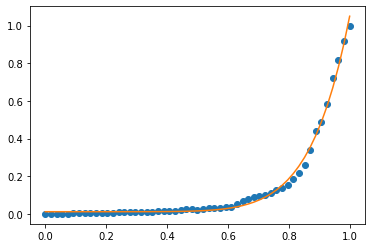

In [192]:
def power(x, b1, b2,b3):
    y = b1 + b2*np.power(x,b3)
    return y


#normalise data
def normalize(x,y):
    x = (x-min(x))/(max(x)-min(x))
    y = (y-min(y))/(max(y)-min(y))
    return x,y

xnew, ynew = normalize(xdata,ydata)

popt2,pcov2 = curve_fit(power, xnew,ynew)
print(popt2)
plt.plot(xnew,ynew, 'o')

x = np.linspace(1960, 2015, 55)
x,y = normalize(x,x)
plt.plot(x,power(x,*popt2))

#this model is far better suited than the sugmoid model as we can see, however we will compare the errors.

## Model Comparison

This will be a bit repetitive, as we'll be redoing some of the stuff done above

For sigmoid
Mean absolute error: 0.05
Residual sum of squares (MSE): 0.01
R2-score: 0.95
For power
Mean absolute error: 0.03
Residual sum of squares (MSE): 0.00
R2-score: 0.99


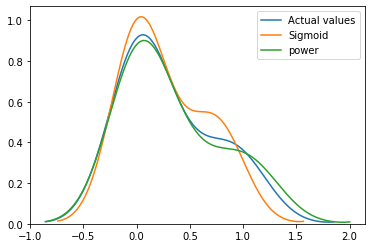

In [229]:
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import r2_score


# split data into train/test
x_new, y_new = normalize(xdata,ydata)
msk = np.random.rand(len(df)) < 0.8
train_x = x_new[msk]
test_x = x_new[~msk]
train_y = y_new[msk]
test_y = y_new[~msk]

# build the model using train set
popt, pcov = curve_fit(sigmoid, train_x, train_y)
popt2, pcov2 = curve_fit(power, train_x, train_y)

# predict using test set
y_hat = sigmoid(test_x, *popt)
y_hat2 = power(test_x,*popt2)

# evaluation
print("For sigmoid")
print("Mean absolute error: %.2f" % np.mean(np.absolute(y_hat - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((y_hat - test_y) ** 2))
print("R2-score: %.2f" % r2_score(y_hat , test_y) )

print("For power")
print("Mean absolute error: %.2f" % np.mean(np.absolute(y_hat2 - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((y_hat2 - test_y) ** 2))
print("R2-score: %.2f" % r2_score(y_hat2 , test_y) )


ax0 = sns.distplot(test_y,hist = False, label = 'Actual values')
sns.distplot(y_hat,hist = False,label = 'Sigmoid', ax = ax0)
sns.distplot(y_hat2, hist = False,label = 'power',ax = ax0)
    #as per the distribtution plot, we notice that the Power model is a much better fit than the sigmoid mode


#note also, the distribution plot changes quite randomly, this might be a symptom of bad analysis, or simply due
#to the way data has been partitioned?

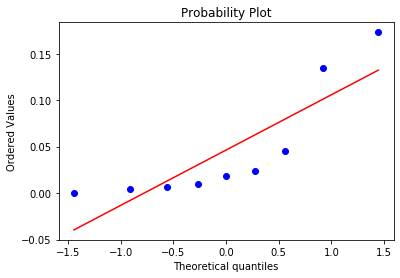

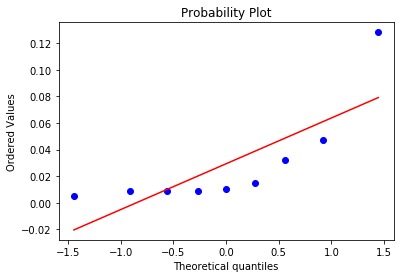

In [231]:

from scipy.stats import probplot as pp
import matplotlib.pyplot
res_power = abs(test_y - y_hat2)
res_sigmoid = abs(test_y-y_hat)

pp(res_sigmoid,dist = 'norm',plot=matplotlib.pyplot)
plt.show()
pp(res_power,dist = 'norm',plot=matplotlib.pyplot) #note that the power plot does not follow a normal distribution
#is this a good thing or a bad thing? What does this mean?
#the sigmoid follows this far better
#Note, the distribtutions are actually quite volatile and dependent on the random partitioning done above.
#I think the sample size is a bit too small?
plt.show()

## Conclusion

The power modelling method is better than the sigmoid method, as shown both visually and by the metrics. It's important to note that the metrics may not quite accurately capture the models, as they both result in very highR2 values and low MAE and MSE values... the visuals do not quite agree with this.